In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
EPOCH = 100

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

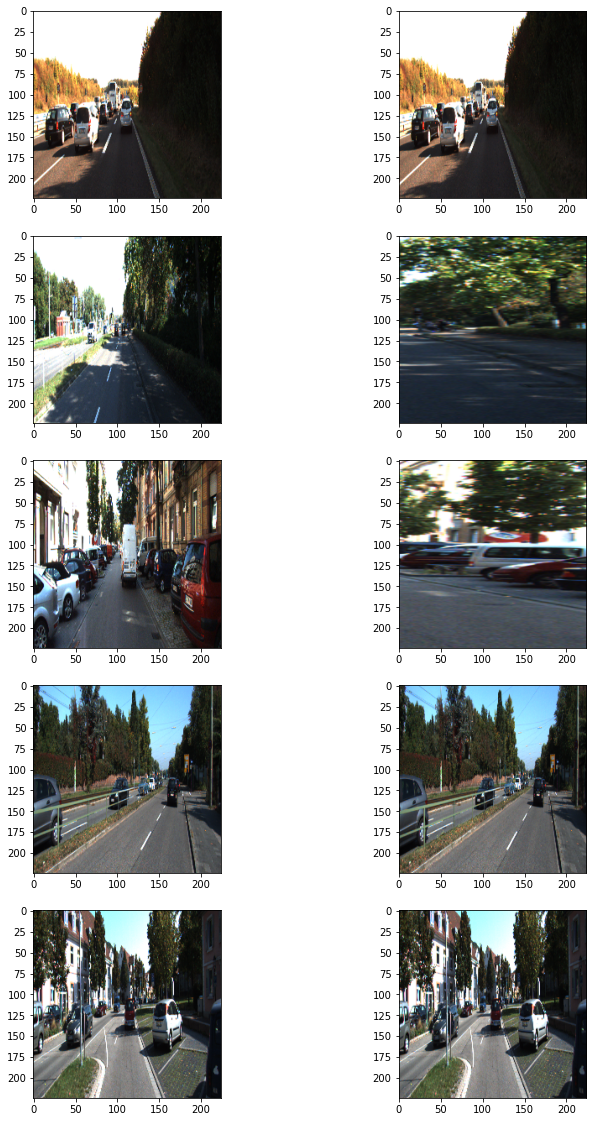

In [4]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [7]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

    #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [8]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=EPOCH,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 29s 836ms/step - loss: 0.6847 - val_loss: 0.6542
Epoch 2/100
11/11 [==============================] - 9s 811ms/step - loss: 0.2797 - val_loss: 0.0336
Epoch 3/100
11/11 [==============================] - 9s 797ms/step - loss: 0.0416 - val_loss: 0.0344
Epoch 4/100
11/11 [==============================] - 9s 800ms/step - loss: 0.0345 - val_loss: 0.0398
Epoch 5/100
11/11 [==============================] - 9s 798ms/step - loss: 0.0335 - val_loss: 0.0253
Epoch 6/100
11/11 [==============================] - 9s 788ms/step - loss: 0.0252 - val_loss: 0.0316
Epoch 7/100
11/11 [==============================] - 9s 783ms/step - loss: 0.0281 - val_loss: 0.0336
Epoch 8/100
11/11 [==============================] - 9s 781ms/step - loss: 0.0239 - val_loss: 0.0253
Epoch 9/100
11/11 [==============================] - 9s 780ms/step - loss: 0.0202 - val_loss: 0.0236
Epoch 10/100
11/11 [==============================] - 9s 781ms/step - loss: 0.0324 - val_l

In [9]:
model = tf.keras.models.load_model(model_path)

In [10]:
def get_output1(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [11]:
def get_output2(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [12]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

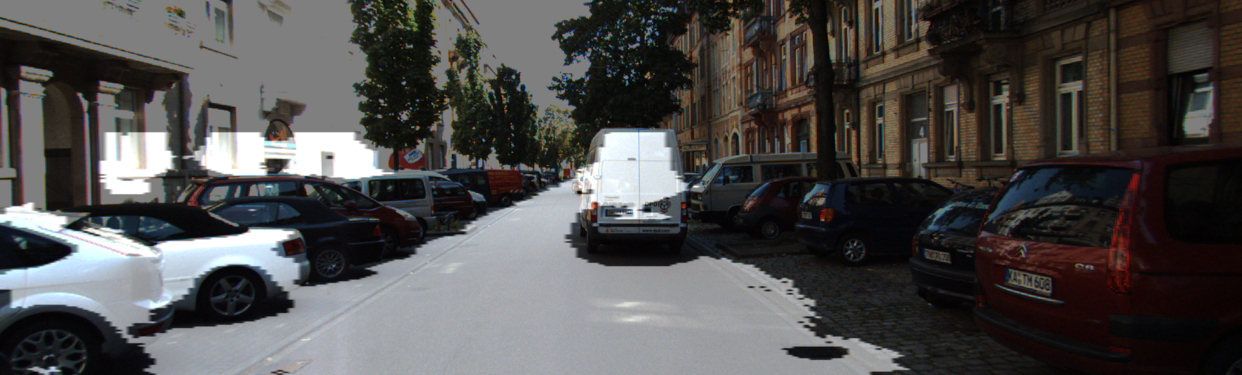

IoU : 0.517076


0.5170756387553757

In [29]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

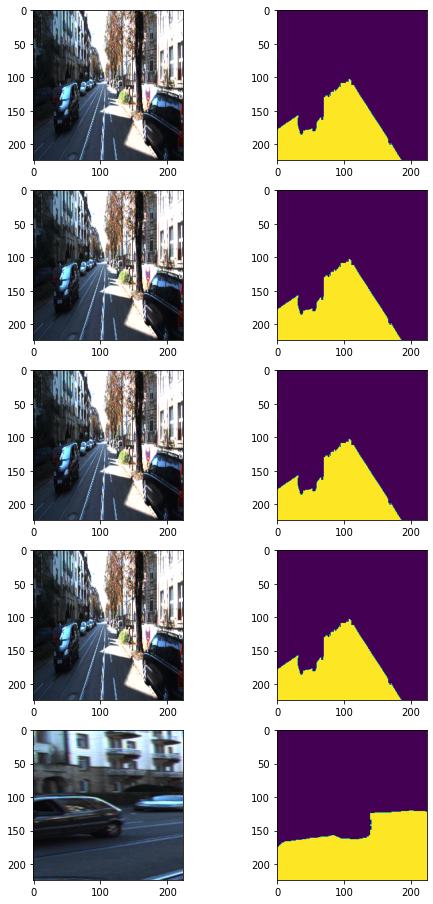

In [14]:
plt.figure(figsize=(8, 16))
for i in range(5) :
    data = next(iter(train_generator))
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(data[0][0, :, :])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(data[1][0, :, :])
plt.show()

In [15]:
def build_UNet_Plus(input_shape=(224, 224, 3), n = 16) :
    
    filters = [n, n*2, n*4, n*8, n*16]
    
    inputs = Input(input_shape)
    
    #conv0_0
    conv001 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn001 = BatchNormalization()(conv001)
    act001 = Activation('relu')(bn001)
    conv002 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act001)
    bn002 = BatchNormalization()(conv002)
    conv00 = Activation('relu')(bn002)
    
    #conv1_0
    conv00_down = MaxPooling2D(strides=2)(conv00)
    conv101 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv00_down)
    bn101 = BatchNormalization()(conv101)
    act101 = Activation('relu')(bn101)
    conv102 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act101)
    bn102 = BatchNormalization()(conv102)
    conv10 = Activation('relu')(bn102)
    
    #conv2_0
    conv10_down = MaxPooling2D(strides=2)(conv10)
    conv201 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv10_down)
    bn201 = BatchNormalization()(conv201)
    act201 = Activation('relu')(bn201)
    conv202 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act201)
    bn202 = BatchNormalization()(conv202)
    conv20 = Activation('relu')(bn202)
    
    #conv3_0
    conv20_down = MaxPooling2D(strides=2)(conv20)
    conv301 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv20_down)
    bn301 = BatchNormalization()(conv301)
    act301 = Activation('relu')(bn301)
    conv302 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act301)
    bn302 = BatchNormalization()(conv302)
    conv30 = Activation('relu')(bn302)
    
    #conv4_0
    conv30_down = MaxPooling2D(strides=2)(conv30)
    conv401 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv30_down)
    bn401 = BatchNormalization()(conv401)
    act401 = Activation('relu')(bn401)
    conv402 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act401)
    bn402 = BatchNormalization()(conv402)
    conv40 = Activation('relu')(bn402)
    
    
    
    #conv0_1
    conv10_up = UpSampling2D()(conv10)
    conv01_in = Concatenate()([conv00, conv10_up])
    
    conv011 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv01_in)
    bn011 = BatchNormalization()(conv011)
    act011 = Activation('relu')(bn011)
    conv012 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act011)
    bn012 = BatchNormalization()(conv012)
    conv01 = Activation('relu')(bn012)
    
    #conv1_1
    conv20_up = UpSampling2D()(conv20)
    conv11_in = Concatenate()([conv10, conv20_up])
    
    conv111 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv11_in)
    bn111 = BatchNormalization()(conv111)
    act111 = Activation('relu')(bn111)
    conv112 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act111)
    bn112 = BatchNormalization()(conv112)
    conv11 = Activation('relu')(bn112)
    
    #conv2_1
    conv30_up = UpSampling2D()(conv30)
    conv21_in = Concatenate()([conv20, conv30_up])
    
    conv211 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv21_in)
    bn211 = BatchNormalization()(conv211)
    act211 = Activation('relu')(bn211)
    conv212 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act211)
    bn212 = BatchNormalization()(conv212)
    conv21 = Activation('relu')(bn212)
    
    #conv3_1
    conv40_up = UpSampling2D()(conv40)
    conv31_in = Concatenate()([conv30, conv40_up])
    
    conv311 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv31_in)
    bn311 = BatchNormalization()(conv311)
    act311 = Activation('relu')(bn311)
    conv312 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act311)
    bn312 = BatchNormalization()(conv312)
    conv31 = Activation('relu')(bn312)
    
    
    
    #conv0_2
    conv11_up = UpSampling2D()(conv11)
    conv02_in = Concatenate()([conv00, conv01, conv11_up])
    
    conv021 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv02_in)
    bn021 = BatchNormalization()(conv021)
    act021 = Activation('relu')(bn021)
    conv022 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act021)
    bn022 = BatchNormalization()(conv022)
    conv02 = Activation('relu')(bn022)
    
    #conv1_2
    conv21_up = UpSampling2D()(conv21)
    conv12_in = Concatenate()([conv10, conv11, conv21_up])
    
    conv121 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv12_in)
    bn121 = BatchNormalization()(conv121)
    act121 = Activation('relu')(bn121)
    conv122 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act121)
    bn122 = BatchNormalization()(conv122)
    conv12 = Activation('relu')(bn122)
    
    #conv2_2
    conv31_up = UpSampling2D()(conv31)
    conv22_in = Concatenate()([conv20, conv21, conv31_up])
    
    conv221 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv22_in)
    bn221 = BatchNormalization()(conv221)
    act221 = Activation('relu')(bn221)
    conv222 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act221)
    bn222 = BatchNormalization()(conv222)
    conv22 = Activation('relu')(bn222)
    
    
    
    #conv0_3
    conv12_up = UpSampling2D()(conv12)
    conv03_in = Concatenate()([conv00, conv01, conv02, conv12_up])
    
    conv031 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv03_in)
    bn031 = BatchNormalization()(conv031)
    act031 = Activation('relu')(bn031)
    conv032 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act031)
    bn032 = BatchNormalization()(conv032)
    conv03 = Activation('relu')(bn032)
    
    #conv1_3
    conv22_up = UpSampling2D()(conv22)
    conv13_in = Concatenate()([conv10, conv11, conv12, conv22_up])
    
    conv131 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv13_in)
    bn131 = BatchNormalization()(conv131)
    act131 = Activation('relu')(bn131)
    conv132 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act131)
    bn132 = BatchNormalization()(conv132)
    conv13 = Activation('relu')(bn132)
    
    
    
    #conv0_4
    conv13_up = UpSampling2D()(conv13)
    conv04_in = Concatenate()([conv00, conv01, conv02, conv03, conv13_up])
    
    conv041 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv04_in)
    bn041 = BatchNormalization()(conv041)
    act041 = Activation('relu')(bn041)
    conv042 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act041)
    bn042 = BatchNormalization()(conv042)
    conv04 = Activation('relu')(bn042)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv04)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [16]:
unet_pp = build_UNet_Plus()
unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0_1 (Conv2D)              (None, 224, 224, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv0_0_1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [18]:
unet_pp.compile(
    optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy')

unet_pp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=EPOCH,
 )

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/unet_pp.h5'
unet_pp.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 13s 444ms/step - loss: 0.7462 - val_loss: 0.6931
Epoch 2/100
11/11 [==============================] - 4s 387ms/step - loss: 0.6783 - val_loss: 0.6634
Epoch 3/100
11/11 [==============================] - 4s 388ms/step - loss: 0.6362 - val_loss: 0.6372
Epoch 4/100
11/11 [==============================] - 4s 390ms/step - loss: 0.6040 - val_loss: 0.6107
Epoch 5/100
11/11 [==============================] - 4s 392ms/step - loss: 0.5721 - val_loss: 0.5980
Epoch 6/100
11/11 [==============================] - 4s 394ms/step - loss: 0.5554 - val_loss: 0.5873
Epoch 7/100
11/11 [==============================] - 4s 395ms/step - loss: 0.5236 - val_loss: 0.5786
Epoch 8/100
11/11 [==============================] - 4s 395ms/step - loss: 0.5356 - val_loss: 0.5625
Epoch 9/100
11/11 [==============================] - 4s 392ms/step - loss: 0.5174 - val_loss: 0.5444
Epoch 10/100
11/11 [==============================] - 4s 391ms/step - loss: 0.4648 - val_l

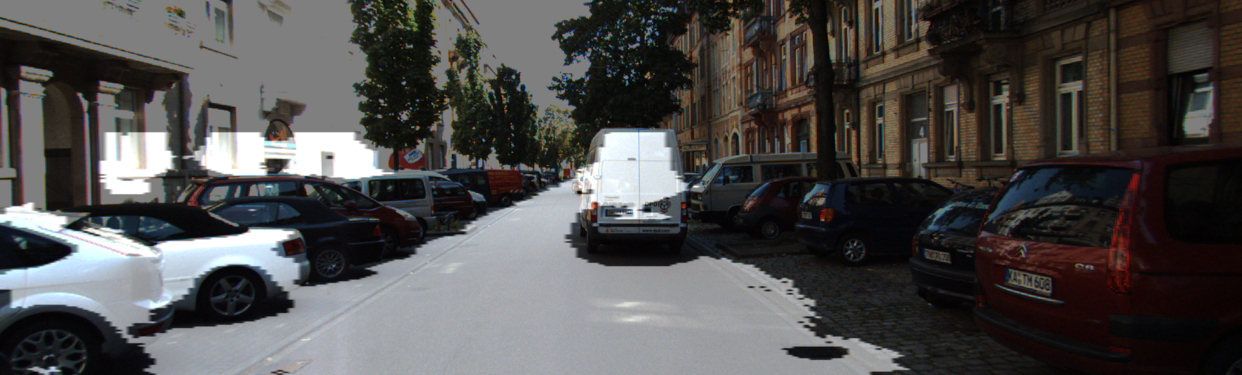

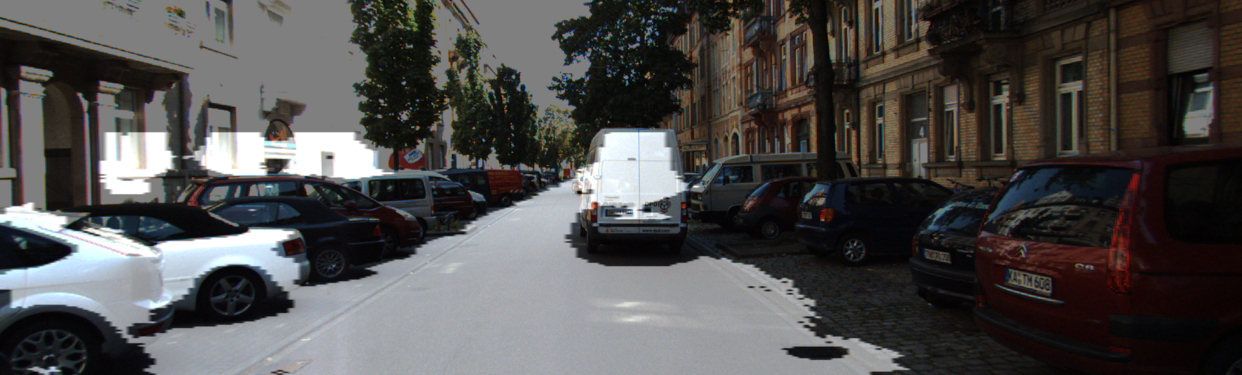

In [30]:


# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output1(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

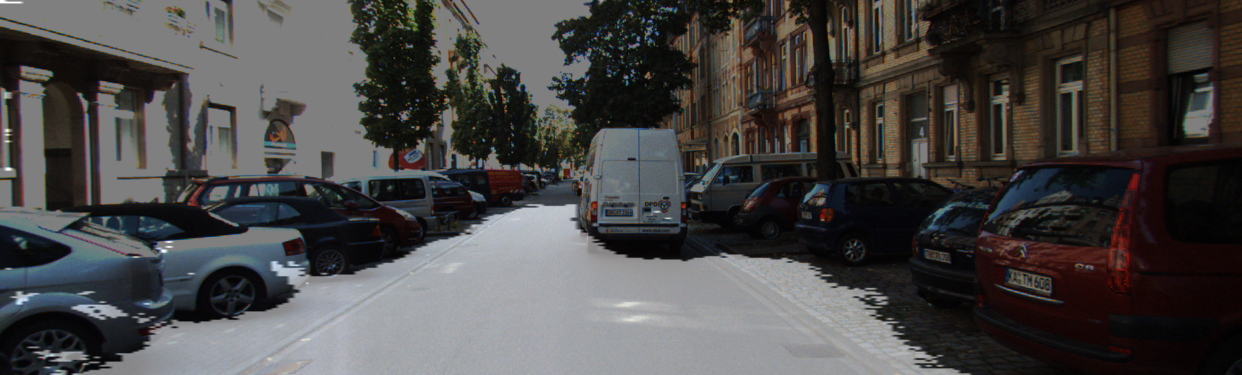

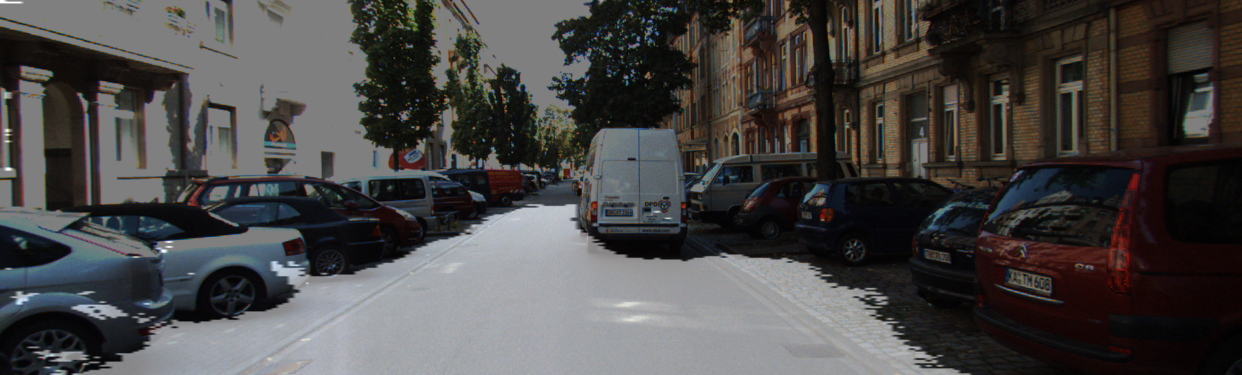

In [31]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4   # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output1(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

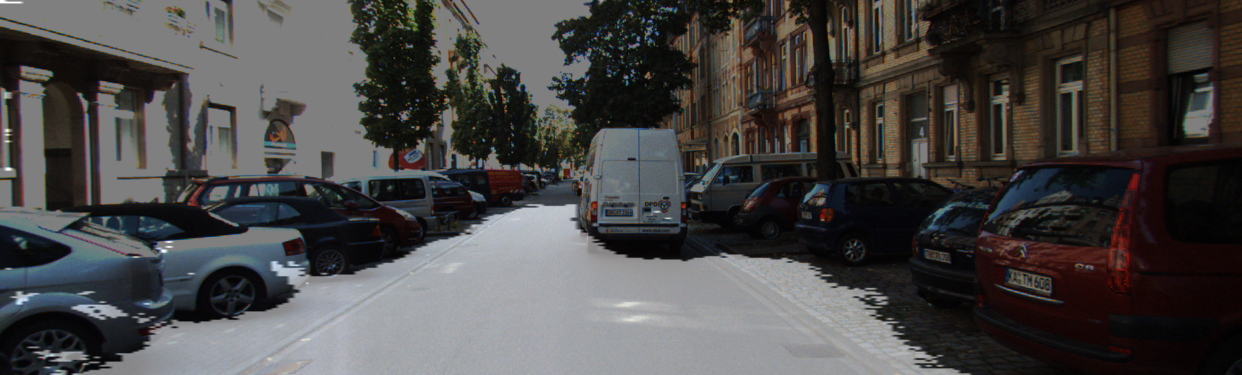

IoU : 0.667910


0.667910447761194

In [32]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4   # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)